No. examples vs accuracy
Vlute$_\infty$ [(1.0, 17.627, 3.133626582876181), (3.0, 32.222, 3.1459940938192323), (5.0, 44.411, 5.502980465046948), (7.0, 51.07, 6.854250871877075), (9.0, 54.926, 6.962683315478697)]
Vlute$_{1000}$ [(1.0, 31.138, 4.647177823335966), (3.0, 46.108, 6.086632851310381), (5.0, 52.512, 7.11800320673868), (7.0, 56.594, 7.695025593188109), (9.0, 60.348, 8.461785570077119)]
Vlute$_{10000}$ [(1.0, 37.778, 6.799623216017179), (3.0, 47.687, 4.707103900858682), (5.0, 58.057, 5.673650263340755), (7.0, 60.71, 5.915533068231668), (9.0, 66.695, 6.713979367666226)]
Vlute$_{B\infty}$ [(1.0, 18.099, 2.562210381115626), (3.0, 34.8, 5.288702930965566), (5.0, 41.265, 5.672421498513053), (7.0, 44.647, 5.557284026299319), (9.0, 49.088, 5.677712696315011)]
Vlute$_{B1000}$ [(1.0, 29.144, 5.323292088865467), (3.0, 42.668, 6.733973073386183), (5.0, 48.51, 6.939705777218708), (7.0, 50.453, 6.966934361163512), (9.0, 53.524, 7.5319169579739675)]
Vlute$_{B10000}$ [(1.0, 31.382, 5.4282159444

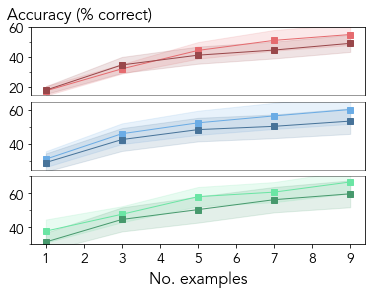

In [37]:
import json
import os
from collections import Callable
from math import sqrt
import matplotlib.pyplot as plt

class Results:
    def __init__(self, data, colors):
        self.results = [Result(d["file"], d["name"], colors[d["name"]]) for d in data]

    def filter_fields(self, fields: list[str]):
        for r in self.results:
            r.filter_fields(fields)

    def aggregate(self, over: str):
        for r in self.results:
            r.aggregate(over)

    def aggregate_multiple(self, over: list[str]):
        for r in self.results:
            r.aggregate_multiple(over)

    def aggregate_std(self, over: str, std_field: str):
        for r in self.results:
            r.aggregate_std(over, std_field)

    def flatten(self):
        for r in self.results:
            r.flatten()

    def filter(self, field: str, cond: Callable[[object], bool]):
        for r in self.results:
            r.filter(field, cond)

    def filter_all(self, id_field: str, field: str, cond: Callable[[object], bool]):

        d = {}
        for r in self.results:
            for e in r.results:
                if e[id_field] not in d:
                    d[e[id_field]] = []

                if cond(Result._field_parser(e, field)):
                    d[e[id_field]].append(e)

        l = len(self.results)
        for i in range(0, l):
            self.results[i].results = [v[i] for k, v in d.items() if len(v) == l]

    def _make_up(self, ax, x_axis, y_axis):
        plt.rcParams["font.family"] = "Avenir"

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis, fontsize=16)
        plt.ylabel(y_axis, fontsize=16, rotation="horizontal", horizontalalignment="left")
        ax.yaxis.set_label_coords(-0.07,3.5)
        ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        #plt.title(title, fontsize=16)

        #plt.legend()

    def plot_errorbar(self, x: Callable, y: Callable, e: Callable = lambda _: 0, title: str = "", x_axis: str = "", y_axis: str = "", y_ticks = [], y_ticks_minor = [], x_ticks = [], x_ticks_minor = []):
        print(title)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

        for r in self.results:
            if "infty" in r.name:
                r.plot_errorbar(ax1, x, y, e)

            if "1000}" in r.name:
                r.plot_errorbar(ax2, x, y, e)

            if "10000}" in r.name:
                r.plot_errorbar(ax3, x, y, e)

        if y_ticks:
            ax1.set_yticks(y_ticks)
            ax2.set_yticks(y_ticks)
            ax3.set_yticks(y_ticks)

        if y_ticks_minor:
            ax1.set_yticks(y_ticks_minor, minor=True)
            ax2.set_yticks(y_ticks_minor, minor=True)
            ax3.set_yticks(y_ticks_minor, minor=True)

        if x_ticks:
            #ax1.set_xticks(x_ticks)
            #ax2.set_xticks(x_ticks)
            ax3.set_xticks(x_ticks)

        if x_ticks_minor:
            #ax1.set_xticks(x_ticks_minor, minor=True)
            #ax2.set_xticks(x_ticks_minor, minor=True)
            ax3.set_xticks(x_ticks_minor, minor=True)

        self._make_up(ax1, x_axis, y_axis)
        self._make_up(ax2, x_axis, y_axis)
        self._make_up(ax3, x_axis, y_axis)

        ax1.spines['bottom'].set_alpha(0.5)
        ax2.spines['bottom'].set_alpha(0.5)
        ax2.spines['top'].set_alpha(0.5)
        ax3.spines['top'].set_alpha(0.5)

        ax1.tick_params(bottom=False)
        ax2.tick_params(bottom=False)

        plt.subplots_adjust(hspace=0.1)

        ax1.set_ylim(15, 60)
        ax2.set_ylim(25, 65)
        ax3.set_ylim(30, 70)


    def save(self, question: int, domain: str, name: str):
        folder = "{}/Q{}/graphs/{}".format(os.getcwd(), question, domain)

        if not os.path.exists(folder):
            os.makedirs(folder)

        plt.savefig("{}/{}.pdf".format(folder, name), bbox_inches='tight')

class Result:
    def __init__(self, file_name, name, color):
        self.name = name
        self.color = color

        self.results = []

        with open(file_name, "r") as file:
            for line in file:
                stripped_line = line.strip()
                obj = json.JSONDecoder().decode(stripped_line)
                self.results.append(obj)

    def filter_fields(self, fields: list[str]):
        for i, res in enumerate(self.results):
            self.results[i] = {f: self._field_parser(res, f) for f in fields}

    @staticmethod
    def _field_parser(obj, field):
        if field == "complexity":
            return int(obj["file"].split("/")[1].split("-")[0])

        if field == "file_tuple":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[0]), int(a[1]), int(a[2])

        if field == "task":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[1])

        if field == "trial":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[2])

        if field == "correct":
            return 100 if obj["test_cost"] == obj["train_cost"] == 0 else 0

        if field == "zero_train_cost":
            return 1 if obj["train_cost"] == 0 else 0

        if field == "overfitted":
            return 1 if obj["test_cost"] > 0 and obj["train_cost"] == 0 else 0

        if field == "explored_per_sec":
            return obj["number_of_explored_programs"] / obj["execution_time"]

        if field == "average_explored_size_tokens":
            a = obj["explored_per_size_tokens"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field == "average_explored_size_sequence":
            a = obj["explored_per_size_sequence"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field in obj:
            return obj[field]

        raise Exception()

    def aggregate(self, over: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def aggregate_multiple(self, fields: list[str]):
        final = {}

        for res in self.results:
            key = tuple([res[field] for field in fields])

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def aggregate_std(self, over: str, std_field: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1, "values": []}
            else:
                final[key]["count"] += 1
                final[key]["values"].append(res[std_field])
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

            total = sum([pow(v - final[key][std_field], 2) for v in value["values"]])
            std = sqrt(total / len(value["values"]))
            ci = 1.645 * std / sqrt(len(value["values"]))
            final[key]["std"] = ci

        self.results = final

    def flatten(self):
        self.results = [self.results[r] for r in self.results]

    def filter(self, field: str, cond: Callable[[object], bool]):
        result = []

        for res in self.results:
            if cond(self._field_parser(res, field)):
                result.append(res)

        self.results = result

    def plot(self, ax, x: Callable, y: Callable):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs)))

        ax.plot(
            xs, ys,
            label=self.name,
            marker='o',
            color=self.color,
        )

    def plot_errorbar(self, ax, x: Callable, y: Callable, e: Callable = lambda _: 0):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        es = [e(r) for r in self.results.items()]
        ci1 = [y(r) - e(r) for r in self.results.items()]
        ci2 = [y(r) + e(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs, es)))

        linestyle = "solid"
        if "Brute" in self.name:
            linestyle = "dashed"

        ax.errorbar(
            xs, ys,
            label=self.name,
            marker='s',
            ms=6,
            color=self.color,
            capsize=5,
            linestyle=linestyle,
            linewidth=1,
        )

        ax.fill_between(
            xs, ci1, ci2,
            color=self.color,
            alpha=0.15,
        )

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        xrs =  [x.__round__(5) for x in xs]
        yrs =  [y.__round__(5) for y in ys]
        print(self.name, list(zip(xrs, yrs)))

        ax.scatter(
                xs, ys,
                label=self.name,
                marker='o',
                linewidths=2.5,
                color=self.color,
        )

        labels = [label(r) for r in self.results.items()]

        for x, y, l in zip(xs, ys, labels):
            ax.annotate(l, (x, y))

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        xs = [x(r) for r in self.results]

        plt.hist(
            xs,
            bins=bins,
        )

        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.title(title)

    def __str__(self):
        return self.results.__str__()

domain = "string"
colors = {
    "Brute_old": "xkcd:grey",
    "Vlute$_\infty$": "#E56B6F",
    "Vlute$_{B\infty}$": "#99474A",
    "Vlute$_{1000}$": "#6BACE5",
    "Vlute$_{B1000}$": "#477399",
    "Vlute$_{10000}$": "#6BE5A4",
    "Vlute$_{B10000}$": "#47996D",
}
data = {
    "string": [
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_string/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_string/VDNS_1000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_string/VDNS_10000.txt"},
        {"name": "Vlute$_{B\infty}$", "file": "../results/hpc/Q3_string/Flute_Brute_inf.txt"},
        {"name": "Vlute$_{B1000}$", "file": "../results/hpc/Q3_string/Flute_Brute_1000.txt"},
        {"name": "Vlute$_{B10000}$", "file": "../results/hpc/Q3_string/Flute_Brute_10000.txt"},
        #{"name": "Brute_old", "file": "../results/hpc/Q1_string/Brute_improved.txt"},
]}[domain]
complexity = {
    "robot": "Grid size",
    "string": "No. examples",
    "pixel": "No. characters",
}[domain]

brute = {"name": "Brute_old", "file": "../results/hpc/Q1_string/Brute_improved.txt"}
brute_result = Result(name=brute["name"], file_name=brute["file"], color=colors[brute["name"]])
brute_result.filter_fields(["file", "correct"])
not_solved_by_brute = [r["file"] for r in brute_result.results if not r["correct"]]

#"""     Complexity vs accuracy of cases not solved by Brute
results = Results(data, colors)
results.filter("file", lambda f: f in not_solved_by_brute)
results.filter("complexity", lambda v: v in [1,3,5,7,9])
results.filter_fields(["complexity", "correct", "trial"])
results.aggregate_multiple(["complexity", "trial"])
results.flatten()
results.aggregate_std("complexity", "correct")
results.plot_errorbar(
    x=lambda t: t[0],
    y=lambda t: t[1]["correct"],
    e=lambda t: t[1]["std"],
    title="{} vs accuracy".format(complexity),
    x_axis=complexity,
    y_axis="Accuracy (% correct)",
    y_ticks=[20, 40, 60],
    y_ticks_minor=[30, 50, 70],
    x_ticks={
        "string": range(1, 10),
        "pixel": range(1, 6),
        "robot": range(2, 12, 2),
    }[domain],
)
results.save(3, domain, "complexity_vs_accuracy")